<a href="https://colab.research.google.com/github/ezzy4me/project/blob/main/classifying_news_topic_dacon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and read library



In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 7.9 MB/s 
     |████████████████████████████████| 448 kB 54.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
!pip install scikit-learn

In [ ]:
#importing neccessary libraries
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import csv
 
f = open('/content/train_data.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
for line in rdr:
    print(line)
f.close()    

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['40654', '대구서 적십자 고액기부자 클럽 가입식 열려', '2']
['40655', '국립중앙박물관 대고려전에 17만2천명 다녀갔다', '3']
['40656', '충북보건과학대 간호학과 덕분에 챌린지 동참', '2']
['40657', '코스피 소폭 하락 출발', '1']
['40658', '이산가족상봉 첫 순간 알아본 혈육…엄마랑 똑 같아', '2']
['40659', '퇴장 세징야 오심 판명 나 2경기 출장정지 징계 취소', '5']
['40660', '인사말 경청하는 사립대학 총장들', '2']
['40661', '유승민 오로지 공화국 정의만 생각하며 탄핵 소추안 표결', '6']
['40662', '영상 운전대 잡자마자 심정지…충돌사고가 운전자 살렸다', '2']
['40663', '속보 뉴타운 해제지역에서도 공공재개발 적극 추진', '1']
['40664', '졸업했는데 일자리 없는 청년 166만명…통계 작성이래 최다', '2']
['40665', '서부TD 부동산업 자회사 주식 1천244억원어치 취득', '1']
['40666', '北 전력 사정 악화로 혜산평양 철도 열흘 이상 걸려', '2']
['40667', '북한군 김정은에 충성 맹세 예식…결사 옹위', '6']
['40668', '학생들에게 인사말 하는 조희연', '2']
['40669', '심리 상담받는 친구도 있어요…외국인 유학생 코로나 블루', '2']
['40670', '백악관서도 엔터 샌드맨…MLB 전설 리베라 자유메달 수상', '5']
['40671', '티몬 내년 상장 목표…미래에셋대우 기업공개 주관사로 선정', '1']
['40672', '렉서스코리아 SUV 뉴 RX 출시', '1']
['40673', '친박 새순론 vs 비박 인적청산…탄핵후 집권당 격변 예고', '6']
['40674', '프로배구 한국전력 악재…김인혁 골절·인대 파열로 시즌아웃', '5']
['40675', '문인화가 이인상 그림·글

In [ ]:
#Loading the Data
df_train = pd.read_csv('/content/train_data.csv')
df_test = pd.read_csv('/content/test_data.csv')
df_train.shape, df_test.shape

((45654, 3), (9131, 2))

#EDA

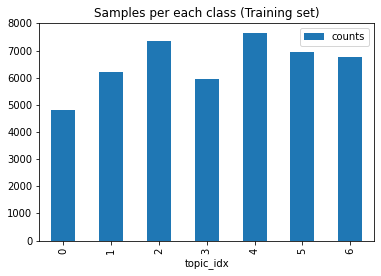

In [ ]:
#Checking number of each categories
df_train.groupby(df_train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

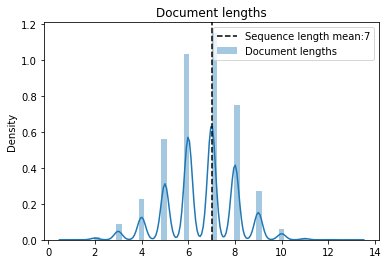


 가장 긴 문장은 13 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있습니다.


In [ ]:
# distribution of stence length
df_train['doc_len'] = df_train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f"\n 가장 긴 문장은 {df_train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {df_train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(df_train)

In [ ]:
df_train.tail()

,index,title,topic_idx,doc_len
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,7
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,7
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,6
45652,45652,답변하는 배기동 국립중앙박물관장,2,3
45653,45653,2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후,2,7


#PREPROCESSING

In [ ]:
from konlpy.tag import Okt
import re

# 감탄사, 조사들은 제거할 수 있도록 정의

# --------
# 1차. 직접 조사 지정
# stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한', '과', '와'])
# okt=Okt()

# def preprocessing(topic, okt, remove_stopwords = True, stop_words = []):
#     # 문장에서 한글만 뽑아냄
#     topic_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\s]", "", topic)
    
#     # okt 라이브러리로 단어의 어간별로 분리
#     word_topic = okt.morphs(topic_text, stem=True)
    
#     # 감탄사와 조사 제거
#     if remove_stopwords:
#         word_topic = [token for token in word_topic if token not in stop_words]
        
#     return word_topic
# ------

# 2차. pos로 (단어, 형태소) 형식
# stop_tags reference
# https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0 

stop_tags = ["Josa", "Exclamation"]

okt=Okt()

def preprocessing(topic, okt, remove_stopwords = True, stop_tags=None):
    # 문장에서 한글만 뽑아냄
    topic_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", topic)
    
    # okt 라이브러리로 단어의 어간별로 분리
    word_topic = okt.pos(topic_text, stem=True)
    
    # 감탄사와 조사 제거 
    word_topic = [token[0] for token in word_topic if not stop_tags or token[1] not in stop_tags]
        
    return word_topic

In [ ]:
clean_train_topic = []

for topic in df_train['title']:
    if type(topic) == str:
        clean_train_topic.append(preprocessing(topic, okt, True, stop_tags))
    else:
        clean_train_topic.append([])

In [ ]:
#q1 왜 처리한 감탄사 조사가 아래서 안사라진 경우가 있음? ex) '공과' -> '공'
#ㄴstopwords 저렇게 일일히 지정하면 전부 다는 못잡을수도 있을 것 같음. 그냥 pos로 (단어, 형태소) 형식으로 형태소분석 한다음에 조사랑 그런거 분리하는 식 추천
clean_train_topic[:4]

[['인천', '핀란드', '항공기', '결항', '휴가', '철', '여행객', '분통'],
 ['실리콘밸리', '넘어서다', '구글', '조원', '들이다', '전역', '거점', '화'],
 ['이란', '외무', '긴장', '완화', '해결', '책', '미국', '경제', '전쟁', '멈추다', '것'],
 ['클린턴', '측근', '기업', '특수', '관계', '조명', '공과', '사', '맞다', '물리다', '종합']]

In [ ]:
type(clean_train_topic)

list

In [ ]:
#join the each list
#lower가 attribute이 스트링의 기본 내장 함수, 나는 리스트들의 리스트들이므로 스트링의 리스트로 바꿔야
clean_train_topic2 = [" ".join(c) for c in clean_train_topic]
clean_train_topic2[:4]

['인천 핀란드 항공기 결항 휴가 철 여행객 분통',
 '실리콘밸리 넘어서다 구글 조원 들이다 전역 거점 화',
 '이란 외무 긴장 완화 해결 책 미국 경제 전쟁 멈추다 것',
 '클린턴 측근 기업 특수 관계 조명 공과 사 맞다 물리다 종합']

#Tokenizing text with scikit-learn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# q2 논문에 따르면, svm으로 주제 분류할 때, tf-idf가 효율적이라고 했음
## 카운트 기반 벡터화는 카운트 값이 높을수록 중요한 단어로 인식 하지만, 단순히 단어의 빈도만 고려한다면 모든 문서에서 자주 쓰일 수밖에 없는 단어들이 (불용어 등) 중요하다고 인식될 수 있습니다. 
##ㄴex)'The'가 A, B 문서에 동시에 출현
## 이런 문제를 보완하기 위해 TF-IDF(Term Frequency - Inverse Document Frequency) 벡터화를 사용합니다.
## TF-IDF는 개별 문서에서 자주 등장하는 단어에 높은 가중치를 주되, 모든 문서에서 전반적으로 자주 등장하는 단어에 대해서는 패널티를페널티를 주는 방식으로 값을 부여합니다. 

#근데 예제들을 보니 리스트를 통째로 갈아 넣음
#그렇게 하자니 이미 입력된 라벨링이 사라져서 이게 맞는 지 의문
#새로운 함수를 쓰면 공식 다큐맨테이션을 확인한다. 예시 적극 활용
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(clean_train_topic2) # 벡터라이저가 단어들을 학습
tfidf_vectorizer.vocabulary_ # 벡터라이저가 학습한 단어사전을 출력
sorted(tfidf_vectorizer.vocabulary_.items()) # 단어사전을 정렬함


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

sp_matrix = tfidf_vectorizer.fit_transform(clean_train_topic2)

word2id = defaultdict(lambda : 0)
for idx, feature in enumerate(tfidf_vectorizer.get_feature_names()):
    word2id[feature] = idx

# 각 행별 [(토큰, tp-idf 값)]
for i, sent in enumerate(clean_train_topic2):
    print('====== document[%d] ======' % i)
    print( [ (token, sp_matrix[i, word2id[token]]) for token in sent.split() ] )

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
====== document[43154] ======
[('통일부', 0.3335990430828839), ('월일', 0.35566861012246687), ('병', 0.0), ('해충', 0.4468376696334602), ('공동', 0.27675691172803196), ('방제', 0.47678420609904953), ('현장', 0.27936295103467046), ('방문', 0.2531552841828523), ('제의', 0.34131919302763597)]
====== document[43155] ======
[('비행기', 0.3304170087398855), ('랜', 0.0), ('딩기', 0.4175350001454888), ('어', 0.0), ('숨다', 0.31507629194687076), ('밀항', 0.4175350001454888), ('시도', 0.26490005852615434), ('인니', 0.30613255492779595), ('말레이', 0.3268109611500164), ('공항', 0.27146482067235966), ('적발', 0.31383569349447216)]
====== document[43156] ======
[('울', 0.0), ('주', 0.0), ('세계', 0.24351578778175037), ('산악', 0.38638732145703), ('영화제', 0.3562801196247584), ('야외', 0.3815561791843586), ('상영작', 0.47934218836819237), ('공개', 0.2436111456922314), ('메루', 0.47934218836819237), ('등', 0.0), ('여', 0.0), ('편', 0.0)]
====== document[43157] ======
[('월', 0.0), ('과학기술', 0.3720530206454266), ('인상', 0.35994

In [ ]:
#단어가 너무 많아서 이렇게 된 것 같다.

print(sp_matrix.toarray())
print(sp_matrix.shape)

#Train classifier with SVM model

In [ ]:
#making train set
X_train = sp_matrix[:]
y_train = df_train["topic_idx"].values[:]

In [ ]:
from sklearn.svm import SVC

#probability False면 하나만 내뱉음, True면 카테고리 모든걸 보여줌
clf = SVC(probability=True, kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

q4는 우선 전처리할때 tfidf_vectorizer를 학습할 때 한번 fit 했으니까 그거 가져와서 transform만 해야딜듯.. 지금은 test단계에서 tfidf를 새로 fit 하는데 애초에 분류기가 학습 데이터로 만들어진 tf-idf feature에 대해 학습된건데 테스트 데이터에 대해서 새로 tf-idf를 구하고 학습하면 학습한 feature와 다른 값을 통해서 계산하게 될테니..


#prediction and evaluating the predict



In [ ]:
#restep for test data
clean_test_topic = []

for topic in df_test['title']:
    if type(topic) == str:
        clean_test_topic.append(preprocessing(topic, okt, True, stop_tags))
    else:
        clean_test_topic.append([])

clean_test_topic2 = [" ".join(c) for c in clean_test_topic]
clean_test_topic2[:4]


sp_matrix_test = tfidf_vectorizer.transform(clean_test_topic2)

In [ ]:
# q4) 전처리를 할때 나눠서 했는데, df_test에 정답이 들어갈 label이 없을 땐 어케하죠?
#making test set
X_test = sp_matrix_test[:]



In [ ]:
predictions = clf.predict(X_test)

#Submission

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')

topic = []
for i in range(len(predictions)):
    topic.append(np.argmax(predictions[i]))

submission['topic_idx']=topic

submission.to_csv('TF-IDF_SCV.csv', index=False)

#NOT NOW

In [ ]:
# from sklearn.linear_model import SGDClassifier
# text_clf = Pipeline([
#      ('vect', CountVectorizer()),
#      ('tfidf', TfidfTransformer()),
#      ('clf', SGDClassifier(loss='hinge', penalty='l2',
#                            alpha=1e-3, random_state=42,
#                            max_iter=5, tol=None)),
#  ])

# >>> text_clf.fit(twenty_train.data, twenty_train.target)
# Pipeline(...)
# >>> predicted = text_clf.predict(docs_test)
# >>> np.mean(predicted == twenty_test.target)
# 0.9101...

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding=u'utf-8', ngram_range=(1, 2))

# features = tfidf.fit_transform(clean_train_topic).toarray()
# labels = clean_train_topic.topic_idx
# features.shape
# 

In [ ]:
# ?TfidfVectorizer()